In [1]:
import pyro
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import random

In [2]:
# Giving the alias and cpt tables for the model
X_alias = ["promotion0", "promotion1"]
Y_alias = ["not-renewed", "renewed"]
Z_alias = ["unhappy", "happy"]


Z_prob = torch.tensor([0.5092,0.4908])
X_prob = torch.tensor([[0.247, 0.753], [0.763, 0.237]])
Y_prob = torch.tensor([[[0.068, 0.932], [0.267, 0.733]],
                     [[0.131, 0.869], [0.313, 0.687]]])

### 2.1.a 
Build the model with Pyro using the values in the table.  Use `pyro.condition` to calculate the causal effect by adjusting for happiness. (5 points)

In [3]:
def model():
    Z = pyro.sample("Z", dist.Categorical(probs=Z_prob))
    X = pyro.sample("X", dist.Categorical(probs=X_prob[Z]))
    Y = pyro.sample("Y", dist.Categorical(probs=Y_prob[X][Z]))
    return{'X': X, 'Y': Y, 'Z': Z}

You are interested in the average causal effect $P(Y=1|\text{do}(X=0)) - P(Y=1|\text{do}(X=1))$

In [4]:
def adjustmentFormula(x_cond, z_probs):
    Z_conditons=[{'Z':torch.tensor(0)}, {'Z': torch.tensor(1)}]
    effect = 0.0
    for idx in range(len(z_probs)):
        data = {}
        data.update(x_cond)
        data.update(Z_conditons[idx])
        
        conditioned_model = pyro.condition(model, data= data)
        T_samples = [conditioned_model()['Y'] for _ in range(1000)]
        T_unique, T_counts = np.unique(T_samples, return_counts=True)
        Y_prob = T_counts[1]/ 1000
        effect += (Y_prob * z_probs[idx])
    return effect

In [5]:
effect_Y1_X0 = adjustmentFormula({"X": torch.tensor(0)}, [0.5092, 0.4908])

In [6]:
effect_Y1_X1 = adjustmentFormula({"X": torch.tensor(1)}, [0.5092, 0.4908])

In [7]:
effect_Y1_X0 - effect_Y1_X1

0.05323920000000004

### 2.1.b
Use `pyro.do` to calculate the causal effect by adjusting for happiness. (5 points)

In [8]:
def interventionUsingDo(x_cond):
    intervention_model = pyro.do(model, data = x_cond)
    Y_posterior_intervened = pyro.infer.Importance(intervention_model, num_samples=10000).run()
    Y_marginal_intervened = EmpiricalMarginal(Y_posterior_intervened,"Y")
    Y_samples_intervened = [Y_marginal_intervened().item() for _ in range(10000)]
    Y_unique_intervened, Y_counts_intervened = np.unique(Y_samples_intervened, return_counts=True)
    return Y_counts_intervened[1]/ len(Y_samples_intervened)

In [9]:
effect_Y1_X0_do = interventionUsingDo({'X': torch.tensor(0)})

In [10]:
effect_Y1_X1_do = interventionUsingDo({'X': torch.tensor(1)})

In [11]:
effect_Y1_X0_do - effect_Y1_X1_do

0.059599999999999986

### Both the causal effect obtained in 2.1.a and 2.a.b are similar.

### 2.2
You are a data scientist investigating the effects of social media use on purchasing a product. You assume the dag shown below. User info here is unobserved. One of the team members argues that social media usage does not drive purchase based on Table 1. Only 15% social media user made the purchase, while 90.25% non social media users made the purchase. Moreover, within each group, no-adblock and adblock, social media users show a much lower rate of purchase than non social media users. However, another team member argues that social media usage increases purchases. When we look at each group, social media user and non social media user as show in Table 2 (Table 1 and Table 2 both represent the same dataset),  advertisement increases purchases in both groups. Among social media users, purchases increases from 10% to 15% for people who have seen advertisement. Among non social media users, purchases increases from 90% to 95% for people who have seen advertisement. Which view is right?

In [12]:
# Giving the alias and cpt tables for the model
X_alias = ["no-social", "social"]
Y_alias = ["no-ad", "ad"]
Z_alias = ["no-purchase", "purchase"]


X2_prob = torch.tensor([0.5, 0.5])
Z2_prob = torch.tensor([[0.95, 0.05], [0.05, 0.95]])
Y2_prob = torch.tensor([[0.14, 0.86], [0.81, 0.19]])


def socialMediaModel():
    X_2 = pyro.sample("X2", dist.Categorical(probs=X2_prob))
    Z_2 = pyro.sample("Z2", dist.Categorical(probs=Z2_prob[X_2]))
    Y_2 = pyro.sample("Y2", dist.Categorical(probs=Y2_prob[Z_2]))
    return{'X2': X_2, 'Y2': Y_2, 'Z2': Z_2}

### 2.2.a
User info is unobserved.  Use `pyro.condition` to calculate the causal effect of social media on product purchase using front-door adjustment (Section 3.4 in [Front Door Criterion](http://bayes.cs.ucla.edu/PRIMER/primer-ch3.pdf)).(5 points) 

In [13]:
def frontDoorAdjustment(x_conds, x_prob, x_idx):
    Z_conditions = [{"Z2": torch.tensor(0)}, {"Z2": torch.tensor(1)}]
    cumProb = 0.0
    for idx in range(len(Z_conditions)):
        first_condition = {}
        first_condition.update(x_conds[x_idx])
        z_condition_model = pyro.condition(fn=socialMediaModel, data = first_condition)
        Z_samples = [z_condition_model()['Z2'] for _ in range(1000)]
        Z_unique, Z_counts = np.unique(Z_samples, return_counts=True)
        Z_prob = Z_counts[idx]/ 1000
        
        # Finding the sum part for each z - iteration
        innerProb = 0.0
        for idx1 in range(len(x_conds)):
            second_condition = {}
            second_condition.update(Z_conditions[idx])
            second_condition.update(x_conds[idx1])
            y_condition_model = pyro.condition(socialMediaModel, data=second_condition)
            Y_samples = [y_condition_model()['Y2'] for _ in range(1000)]
            Y_unique, Y_counts = np.unique(Y_samples, return_counts=True)
            Y_prob = Y_counts[1]/ 1000
            innerProb += (Y_prob * x_prob[idx1])
        cumProb += (Z_prob * innerProb)
    return cumProb
            

In [14]:
X_conds = [{"X2": torch.tensor(0)}, {"X2": torch.tensor(1)}]
X_prob_1 = [0.5, 0.5]


In [15]:
frontDoorAdjustment(X_conds, X_prob_1, 0) -  frontDoorAdjustment(X_conds, X_prob_1, 1)

0.6186054999999999

### 2.2.b
Verify your result using do-calculus with `pyro.do`.($P(Y=1|\text{do}(X=0)) - P(Y=1|\text{do}(X=1))$) (5 points)


In [16]:
def interventionUsingDoSocial(x_cond):
    intervention_model = pyro.do(socialMediaModel, data = x_cond)
    Y_posterior_intervened = pyro.infer.Importance(intervention_model, num_samples=10000).run()
    Y_marginal_intervened = EmpiricalMarginal(Y_posterior_intervened,"Y2")
    Y_samples_intervened = [Y_marginal_intervened().item() for _ in range(10000)]
    Y_unique_intervened, Y_counts_intervened = np.unique(Y_samples_intervened, return_counts=True)
    return Y_counts_intervened[1]/ len(Y_samples_intervened)

In [17]:
interventionUsingDoSocial({"X2": torch.tensor(0)}) - interventionUsingDoSocial({"X2": torch.tensor(1)})

0.6065999999999999

### Both the causal effect obtained in 2.2.a and 2.2.b are similar

### 3.1 Defining the propensity function

In [18]:
def propensity(x, z):
    return X_prob[z][x]

In [19]:
propensity(0, 1)

tensor(0.7630)

### 3.2 Displaying the 10 samples generated for the model given in 2.1

In [20]:
xs = []
ys = []
zs = []
ps = []
trace_handler = pyro.poutine.trace(model)
for i in range(1000):
    trace = trace_handler.get_trace()
    x = trace.nodes['X']['value']
    y = trace.nodes['Y']['value']
    z = trace.nodes['Z']['value']
    log_prob = trace.log_prob_sum()
    p = np.exp(log_prob)
    xs.append(int(x))
    ys.append(int(y))
    zs.append(int(z))
    ps.append(p)
data = pd.DataFrame({"X": xs, "Y": ys, "Z": zs, "P": ps})


In [21]:
data.head(10)

,X,Y,Z,P
0,1,1,0,tensor(0.3332)
1,1,1,0,tensor(0.3332)
2,0,1,1,tensor(0.2745)
3,1,0,0,tensor(0.0502)
4,1,1,0,tensor(0.3332)
5,0,0,1,tensor(0.1000)
6,1,1,0,tensor(0.3332)
7,0,1,1,tensor(0.2745)
8,1,1,1,tensor(0.0799)
9,0,1,1,tensor(0.2745)


### 3.3 Computing the inverse probability weighting using propensity score

In [22]:
# Using the data generated above, i re-weight the joint probability by propensity.

data["inverse_weighted_prob"] = data.apply(lambda x: x["P"]/ (propensity(x["X"], x["Z"])), axis=1)

In [23]:
data.drop_duplicates(subset=['X', 'Y', 'Z'], inplace=True)
data.reset_index(drop=True)

,X,Y,Z,P,inverse_weighted_prob
0,1,1,0,tensor(0.3332),tensor(0.4425)
1,0,1,1,tensor(0.2745),tensor(0.3598)
2,1,0,0,tensor(0.0502),tensor(0.0667)
3,0,0,1,tensor(0.1000),tensor(0.1310)
4,1,1,1,tensor(0.0799),tensor(0.3372)
5,0,1,0,tensor(0.1172),tensor(0.4746)
6,1,0,1,tensor(0.0364),tensor(0.1536)
7,0,0,0,tensor(0.0086),tensor(0.0346)


In [24]:
combinations = data[['X', 'Y', 'Z']].apply(lambda x: x.to_dict(), axis=1).values

In [25]:
inv_weighted_prob = list(data["inverse_weighted_prob"])


### 3.4 Generating samples from the inverse weighting probability distribution

In [26]:
weighted_samples = pd.DataFrame.from_records(random.choices(combinations, inv_weighted_prob,k=1000))

In [27]:
weighted_samples.head()

,X,Y,Z
0,1,1,1
1,0,1,0
2,0,1,1
3,0,1,0
4,1,0,1


### 3.5 Checking whether the causal estimate is same as 2.1

In [28]:
def filterIt(df, var, value):
    return df[df[var]==value]

In [29]:
def computeProb(df, var, value):
    return sum(df[var]==value)/(df.shape[0])

In [30]:
def causalEffect(df, xval):
    cumProb = 0.0
    for z in range(df["Z"].nunique()):
        ydf = filterIt(filterIt(df, "Z", z), "X", xval)
        yprob = computeProb(ydf, "Y", 1)
        zprob = computeProb(df, "Z", z)
        cumProb+= (yprob * zprob)
    return cumProb

In [31]:
causalEffect(weighted_samples, 0) - causalEffect(weighted_samples, 1)

0.06200804901366552

### The causal estimate is similar to what is obtained in 2.1

### 4.1 Defining the model and generating 10 samples

In [32]:
def scm1():
    X = pyro.sample('X', dist.Normal(0.0, 1.0))
    Y = X ** 2 + pyro.sample('Ny', dist.Normal(0.0, 1.0))
    Y = pyro.sample('Y', dist.Normal(Y, 0.001))
    return X, Y

In [33]:
trace_scm = pyro.poutine.trace(scm1)
for _ in range(10):
    trace = trace_scm.get_trace()
    x = trace.nodes['X']['value']
    y = trace.nodes['Y']['value']
    print(f' The value of x is {x} and the value of y is {y}')

 The value of x is -0.5521014332771301 and the value of y is 2.8549365997314453
 The value of x is -0.08818693459033966 and the value of y is 0.8312249183654785
 The value of x is 0.5461435317993164 and the value of y is 0.1130787804722786
 The value of x is -0.18929176032543182 and the value of y is -0.912778913974762
 The value of x is 0.41813671588897705 and the value of y is -1.5690648555755615
 The value of x is -0.2518658936023712 and the value of y is -1.1397367715835571
 The value of x is 0.09925052523612976 and the value of y is 0.8712673783302307
 The value of x is 1.3132648468017578 and the value of y is 0.6808860898017883
 The value of x is 1.1282209157943726 and the value of y is 0.7220373749732971
 The value of x is -1.107576847076416 and the value of y is 1.1398751735687256


### 4.2

### 4.2.a The DAG can be represented as

<img src='https://g.gravizo.com/svg?
 digraph G {
   Nx -> X;
   X -> Y;
   Ny -> Y
 }
'/>

### 4.2.b

1. The mean of the distribution $P_{Y}^{M}$is 0
2. The variance of the distribution  $P_{Y}^{M}$ is 17 
3. Y = 4 * N(0,1) + N(0,1) --> The variance gets squared when there's a multiplicative factor. --> 16 + 1 --> 17

### 4.2.c

1. The mean of the distribution ${P_{Y}^{M:do(X=2)}}$ is 8 
2. The variance of the distribution $P_{Y}^{M:do(X=2)}$ is 1
3. Y = 4 * 2 (setting the value of x =2 ) + 0 --> Mean.

### 4.2.d
1. The distribution ${P_{Y}^{M:X=2}}$ doesn't differ from ${P_{Y}^{M:do(X=2)}}$ distribution because there isn't any other source that affects X. So, conditioning it or intervening on it doesn't make any difference.

### 4.2.e is answered in the end , as the image is attached separately .

### 4.2.f
1. The mean of the distribution ${P_{X}^{M:do(Y=2)}}$ is 0
2. The variance of the distribution  ${P_{X}^{M:do(Y=2)}}$ is 1
3. Since the sources of Y are removed. The values of X doesn't affect Y in any way. Hence the mean and variance of X remains same

### 4.2.g 

In [34]:
def scm2():
    X = pyro.sample('X', dist.Normal(0.0, 1.0))
    Y = 4 * X + pyro.sample('Ny', dist.Normal(0.0, 1.0))
    Y = pyro.sample('Y', dist.Normal(Y, 0.001))
    return X, Y

trace_scm = pyro.poutine.trace(scm2)
for _ in range(10):
    trace = trace_scm.get_trace()
    x = trace.nodes['X']['value']
    y = trace.nodes['Y']['value']
    print(f' The value of x is {x} and the value of y is {y}')

 The value of x is 1.3833633661270142 and the value of y is 5.738138198852539
 The value of x is 0.07725183665752411 and the value of y is 0.3900867700576782
 The value of x is -0.7231635451316833 and the value of y is -3.6485979557037354
 The value of x is -1.0205142498016357 and the value of y is -3.050013542175293
 The value of x is 0.13883854448795319 and the value of y is 0.6668169498443604
 The value of x is 0.6039068698883057 and the value of y is 1.5654387474060059
 The value of x is 1.5974762439727783 and the value of y is 7.456148147583008
 The value of x is -0.814222514629364 and the value of y is -2.912876844406128
 The value of x is 0.9170505404472351 and the value of y is 2.855215549468994
 The value of x is 0.5865408778190613 and the value of y is 2.7083709239959717


### 4.2.h

In [35]:
conditioned_model = pyro.poutine.do(scm2, data={"X": torch.tensor(2.0)})

In [36]:
traced_model = pyro.poutine.trace(conditioned_model)

In [37]:
y_vals = []
for _ in range(100):
    trace = traced_model.get_trace()
    y = trace.nodes['Y']['value']
    y_vals.append(y)

(array([ 5.,  7.,  9., 15., 21., 19., 12.,  6.,  3.,  3.]),
 array([ 5.6756163,  6.182397 ,  6.6891775,  7.1959577,  7.7027383,
         8.209518 ,  8.716299 ,  9.22308  ,  9.72986  , 10.236641 ,
        10.743422 ], dtype=float32),
 <a list of 10 Patch objects>)

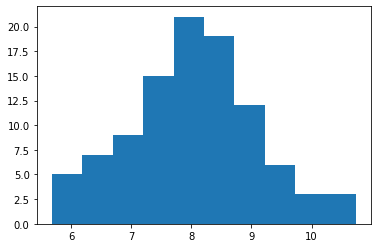

In [38]:
plt.hist(y_vals)

In [39]:
np.mean(y_vals) #approximately around 8

8.0432205

### The mean is centered around 8, which is what we got for ${P_{Y}^{M:do(X=2)}}$ in 4.2.c and we stated in 4.2.d that the ${P_{Y}^{M:(X=2)}}$ distribution doesn't change much to ${P_{Y}^{M:do(X=2)}}$ distribution, which is what we see here

### 4.2.i

In [40]:
conditioned_model_y = pyro.poutine.condition(scm2, data={"Y": torch.tensor(2.0)})

In [50]:
nuts_kernel = pyro.infer.NUTS(conditioned_model_y)
mcmc = pyro.infer.MCMC(nuts_kernel,
            num_samples=10)
mcmc.run()

Sample: 100%|██████████| 20/20 [00:05,  3.63it/s, step size=2.03e-04, acc. prob=0.942]


In [51]:
mcmc.get_samples()["X"]

tensor([0.2253, 0.2256, 0.1948, 0.1952, 0.1953, 0.1953, 0.1951, 0.1947, 0.2294,
        0.1509])